In [19]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics.pairwise import cosine_similarity


In [32]:
#Load Dataset
df = pd.read_csv("data/features_30_sec.csv")

df.head()


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Shape: (1000, 60)

Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


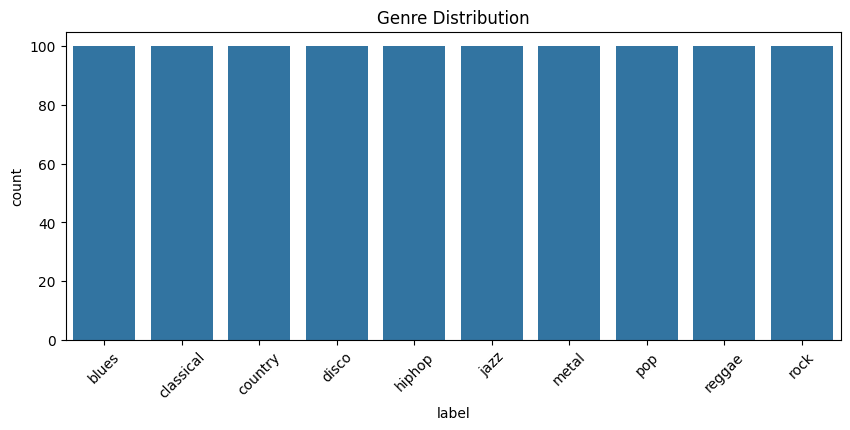

In [33]:
#Explore Dataset
print("Shape:", df.shape)
print("\nGenres:", df["label"].unique())

plt.figure(figsize=(10,4))
sns.countplot(x=df["label"])
plt.xticks(rotation=45)
plt.title("Genre Distribution")
plt.show()


In [34]:
#Preprocessing

# Drop non-feature columns
X = df.drop(["filename", "length", "label"], axis=1)

# Encode genre labels
le = LabelEncoder()
y = le.fit_transform(df["label"])

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (800, 57)
Test size: (200, 57)


In [35]:
#Train Genre Classification Model

model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       blues       0.68      0.75      0.71        20
   classical       1.00      1.00      1.00        13
     country       0.74      0.63      0.68        27
       disco       0.57      0.57      0.57        21
      hiphop       0.50      0.73      0.59        15
        jazz       0.83      0.91      0.87        22
       metal       0.72      0.92      0.81        25
         pop       0.64      0.54      0.58        13
      reggae       0.59      0.43      0.50        23
        rock       0.53      0.38      0.44        21

    accuracy                           0.68       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.68      0.68      0.67       200



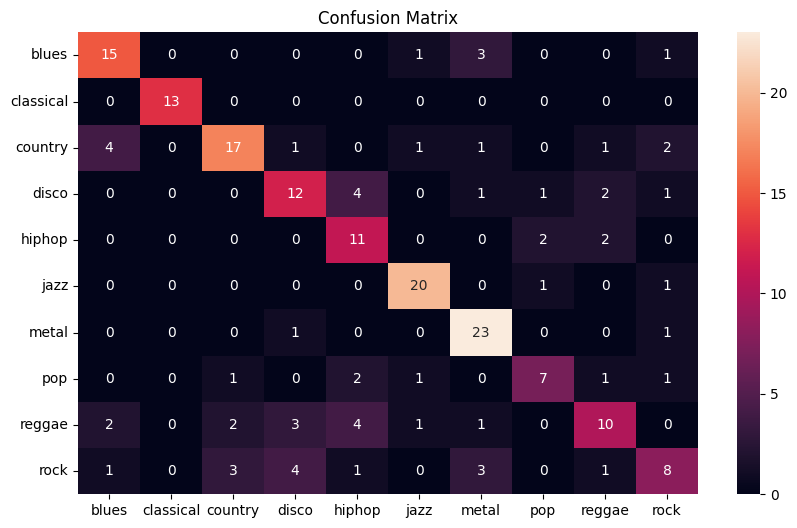

In [36]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()


In [37]:
#Mood Mapping
genre_to_mood = {
    'pop': 'happy',
    'rock': 'energetic',
    'metal': 'aggressive',
    'blues': 'sad',
    'country': 'calm',
    'disco': 'happy',
    'hiphop': 'excited',
    'classical': 'peaceful',
    'reggae': 'chill',
    'jazz': 'calm'
}

df["mood"] = df["label"].map(genre_to_mood)

df[["label", "mood"]].head()


,label,mood
0,blues,sad
1,blues,sad
2,blues,sad
3,blues,sad
4,blues,sad


In [38]:
#Predict Mood for Any Song Features
def predict_genre_and_mood(features):
    # Convert to DataFrame to avoid warning
    features_df = pd.DataFrame([features], columns=X.columns)
    
    # Scale correctly
    scaled = scaler.transform(features_df)
    
    # Predict
    genre_index = model.predict(scaled)[0]
    genre = le.inverse_transform([genre_index])[0]
    
    # Mood mapping
    mood = genre_to_mood.get(genre, "unknown")
    return genre, mood

# Test using the first song
sample = X.iloc[0].values
predict_genre_and_mood(sample)


('blues', 'sad')

In [39]:
#Recommendation System
def recommend_songs(mood, top_n=5):
    mood_df = df[df["mood"] == mood]
    if len(mood_df) == 0:
        print("No songs found for this mood.")
        return None
    
    # Pick a random mood song as reference
    sample = mood_df.sample(1)
    sample_features = scaler.transform(
        sample.drop(['filename','length','label','mood'], axis=1)
    )
    
    # Compute similarity
    features_scaled = scaler.transform(
        df.drop(['filename','length','label','mood'], axis=1)
    )
    sim_scores = cosine_similarity(sample_features, features_scaled)[0]
    
    # Top recommendations
    top_indices = np.argsort(sim_scores)[-top_n:]
    
    return df.iloc[top_indices][['filename','label','mood']]


In [40]:
#Try Recommendations
recommend_songs("happy", top_n=5)


,filename,label,mood
215,country.00015.wav,country,calm
224,country.00024.wav,country,calm
884,reggae.00084.wav,reggae,chill
148,classical.00048.wav,classical,peaceful
320,disco.00020.wav,disco,happy


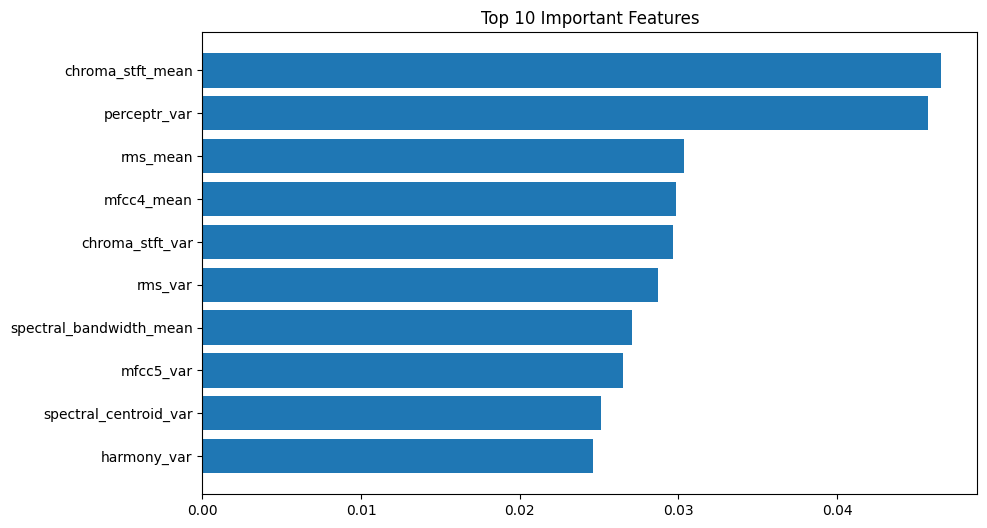

In [41]:
#Visualizations
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 10 Important Features")
plt.show()


In [26]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as id


In [42]:
path = r"data\genres_original\blues\blues.00081.wav"  # your audio file path

y, sr = librosa.load(path)

print("Audio Loaded:")
print("Sampling Rate:", sr)
print("Duration:", librosa.get_duration(y=y, sr=sr))

# Play audio
id.Audio(path)


Audio Loaded:
Sampling Rate: 22050
Duration: 30.013333333333332


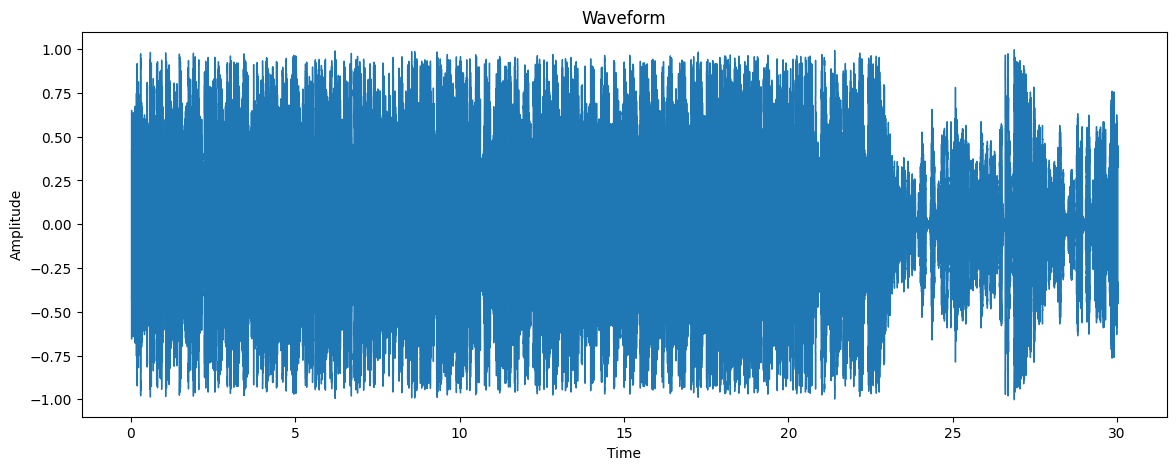

In [ ]:
#Waveform Plot of Blue
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio
y, sr = librosa.load(path)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


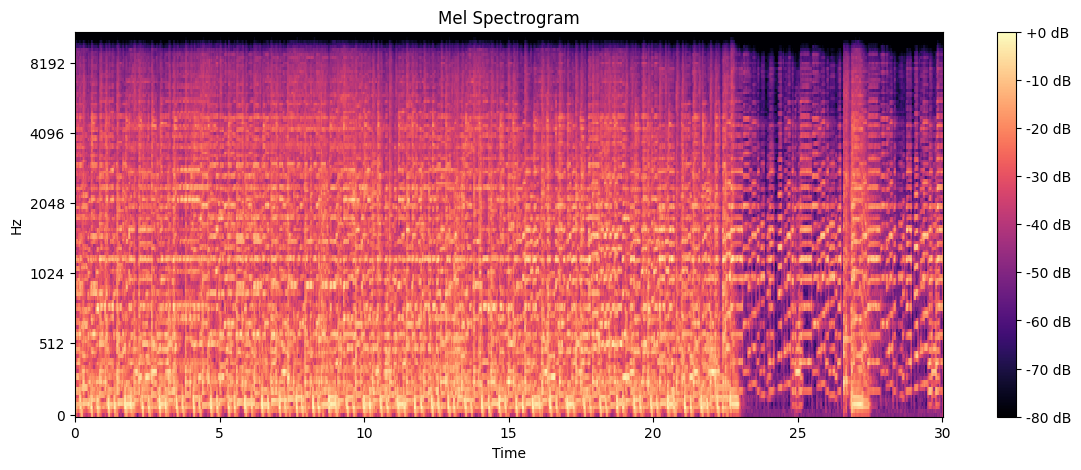

In [43]:
#Spectrogram (Mel Spectrogram) of Blue
# Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_spec_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()


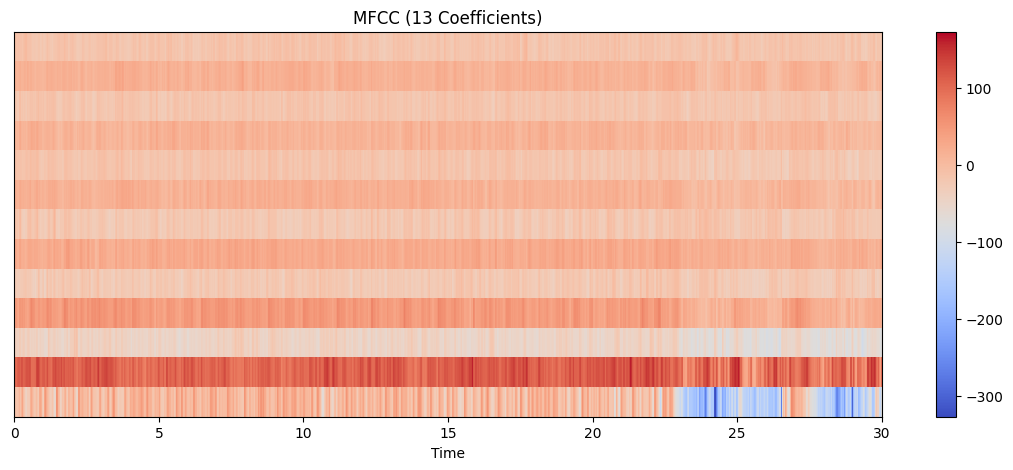

In [44]:
#MFCC Plot (13 Coefficients) of blue
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC (13 Coefficients)")
plt.show()
